In [1]:
!wget https://github.com/Rutvik1999/Social-Distancing---Data/blob/master/TestVideo.avi.zip?raw=true
!unzip /content/TestVideo.avi.zip?raw=true
!rm -rf /content/__MACOSX
#!wget https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5

--2020-07-15 06:25:47--  https://github.com/Rutvik1999/Social-Distancing---Data/blob/master/TestVideo.avi.zip?raw=true
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/Rutvik1999/Social-Distancing---Data/raw/master/TestVideo.avi.zip [following]
--2020-07-15 06:25:47--  https://github.com/Rutvik1999/Social-Distancing---Data/raw/master/TestVideo.avi.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Rutvik1999/Social-Distancing---Data/master/TestVideo.avi.zip [following]
--2020-07-15 06:25:48--  https://raw.githubusercontent.com/Rutvik1999/Social-Distancing---Data/master/TestVideo.avi.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com

In [2]:
!git clone https://github.com/matterport/Mask_RCNN
import os 
os.chdir('Mask_RCNN/samples')

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 116.76 MiB | 29.79 MiB/s, done.
Resolving deltas: 100% (566/566), done.


In [3]:
import sys
import itertools
import cv2
from google.colab.patches import cv2_imshow
import random
import math
import time
from tqdm import tqdm
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt
import imutils
from scipy.spatial import distance as dist
%matplotlib inline 
%tensorflow_version 1
# Root directory of the project
ROOT_DIR = os.path.abspath("../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))  # To find local version
import coco


# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "images")


`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.


Using TensorFlow backend.


... done downloading pretrained model!


In [20]:
batch_size = 1
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = batch_size

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

## Mask RCNN(Mask Regional Convolutional Neural Network)
Mask RCNN is a deep neural network aimed to solve instance segmentation problem in machine learning or computer vision. In other words, it can separate different objects in a image or a video. You give it a image, it gives you the object bounding boxes, classes and masks.

In [5]:
# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO
model.load_weights(COCO_MODEL_PATH, by_name=True)


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.


In [6]:
# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

In [7]:
%cd /content/
%ls

/content
 Mask_RCNN/   sample_data/   TestVideo.avi  'TestVideo.avi.zip?raw=true'


The model.detect detects the objects present in the frame and returns the results obtained. Also the objects detected are bound in rectangles relative to the area they cover.

rois - Region of Interests

masks - Refer to the object detected and selects it.

class_ids - Holds the value of class id it thinks the object is.

scores - returns the probability of the object deteced

True



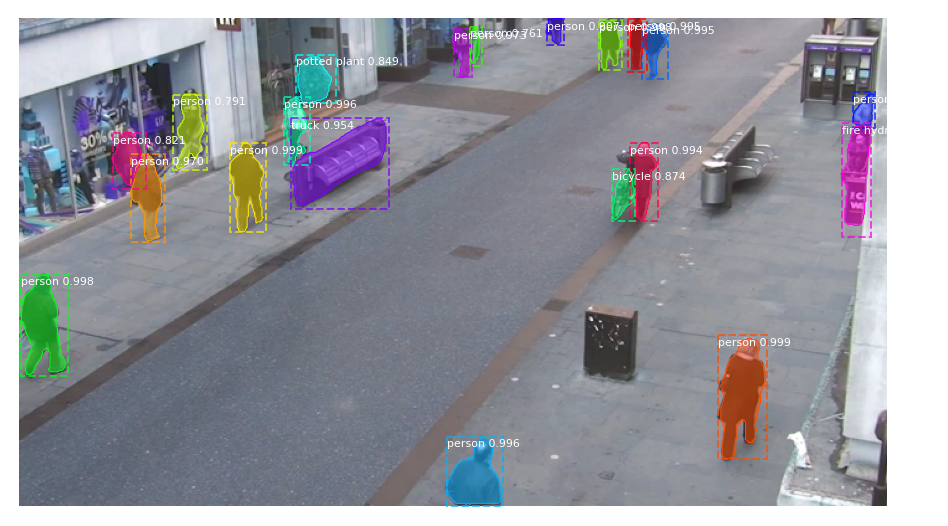

In [8]:
cap = cv2.VideoCapture("TestVideo.avi")
print(cap.isOpened())
while(cap.isOpened()):
    ret, frame = cap.read()
    if ret is True:
      new_width = 700
      new_height = int((new_width / int(cap.get(3))) * int(cap.get(4)))
      frame = imutils.resize(frame, width=new_width, height=new_height)
      image = frame
    break
cap.release()
results = model.detect([image], verbose=0)
# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])

We further extract only humans from the frame and ignore the other classes predicted by the model.

In [9]:
def detect_person_only(r, acc):
  r_person = {}
  l_rois = []
  l_class_ids = []
  l_masks = []
  l_scores = []
  for (rois, class_ids, masks, scores) in zip(r['rois'], r['class_ids'], r['masks'].T, r['scores']):
    if class_names[class_ids] == 'person' and scores >= acc:
      l_rois.append(rois)
      l_class_ids.append(class_ids)
      l_masks.append(masks)
      l_scores.append(scores)
  r_person['rois'] = np.array(l_rois, dtype=np.int32)
  r_person['class_ids'] = np.array(l_class_ids, dtype=np.int32)
  r_person['scores'] = np.array(l_scores, dtype=np.float32)
  r_person['masks'] = np.array(l_masks, dtype=np.bool).T

  return r_person

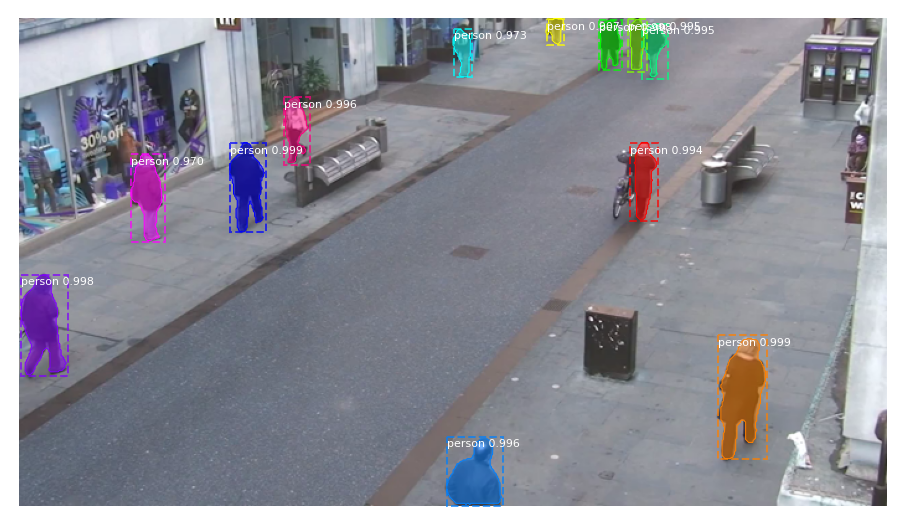

In [10]:
r_person = detect_person_only(r, 0.85)
visualize.display_instances(image, r_person['rois'], r_person['masks'], r_person['class_ids'], 
                            class_names, r_person['scores'])

In [11]:
# print(r_person['rois'].shape)
# print(r_person['class_ids'].shape)
# print(r_person['masks'].shape)
# print(r_person['scores'].shape)

In [12]:
# print(r['rois'].shape)
# print(r['class_ids'].shape)
# print(r['masks'].shape)
# print(r['scores'].shape)

In [13]:
# define random colors
def color_func(N, isViolateVect):
  colors = [tuple([255,100,0]) for _ in range(N)]
  for i in range(0,N):
    if isViolateVect[i] == True:
      colors[i] = tuple([0,0,255])
  return colors
#apply mask to image
def apply_mask(image, mask, color, alpha=0.5):
 
  for n, c in enumerate(color):
    image[:, :, n] = np.where(
    mask == 1,
    image[:, :, n] * (1 - alpha) + alpha * c,
    image[:, :, n]
    )
    return image
#take the image and apply the mask, box, and Label
def display_instances(image, boxes, masks, ids, names, scores, isViolateVect, centroids, pairs):
  n_instances = boxes.shape[0]
  colors = color_func(n_instances, isViolateVect)
  if not n_instances:
    print('NO INSTANCES TO DISPLAY')
  else:
    assert boxes.shape[0] == masks.shape[-1] == ids.shape[0]
  for i, color in enumerate(colors):
    if not np.any(boxes[i]):
      continue
    y1, x1, y2, x2 = boxes[i]
    cX, cY = centroids[i]
    h = pairs[i]
    #print("Pairs[i] = ", h)
    label = names[ids[i]]
    score = scores[i] if scores is not None else None
    caption = '{} {:.2f}'.format(label, score) if score else label
    mask = masks[:, :, i]
    image = apply_mask(image, mask, color)
    image = cv2.rectangle(image, (x1, y1), (x2, y2), color, 1)
    image = cv2.circle(image, (cX, cY), 5, color, 1)
    #print((cX, cY))
    image = cv2.line(image, tuple(h[0]), tuple(h[1]), (0, 0, 255), 2)
    #print(h)
    image = cv2.putText(image, caption, (x1, y1), cv2.FONT_HERSHEY_COMPLEX, 0.32, color, 1)
  return image

def centroid_calc(point_list):
    centroid_list = []
    for box in point_list:
        y1, x1, y2, x2 = box
        width, height = x2 - x1, y2 - y1
        c_x, c_y = width // 2, height // 2
        centroid_list.append((c_x + x1, c_y + y1))
    return centroid_list

The cdist function from the scipy.spatial.distance is used to calculate the distance between each pair of the two centroids of the rectangle. Therefore it gives us the distance(in pixels) between 2 persons which is further compared with the user entered threshold(minimum distance to be maintained) to calculate and show the violations.

In [14]:
frame_count = 0
frames = []
min_distance = int(input("Enter the threshold(minimum distance to be maintained in Pixels) : "))
violations_num_people = set()
cap = cv2.VideoCapture('/content/TestVideo.avi')
fourcc = cv2.VideoWriter_fourcc(*'XVID')
new_width = 700
new_height = int((new_width / int(cap.get(3))) * int(cap.get(4)))
out = cv2.VideoWriter('/content/out.mp4', fourcc, int(cap.get(5)), ( new_width , new_height))
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
pbar = tqdm(total=total_frames, position=0, leave=True)
while(cap.isOpened()):
    violate = set()
    pairs = list()
    isViolateVect = list()
    ret, frame = cap.read()
    
    if ret is True:
      frame = imutils.resize(frame, width=new_width, height=new_height)
      frame_count += 1
      frames.append(frame)
      if len(frames) == batch_size:
        results = model.detect(frames, verbose=0)
        for i, item in enumerate(zip(frames, results)):
            frame = item[0]
            r = item[1]
            r = detect_person_only(r, 0.80)
            centroids = np.array(centroid_calc(r['rois']))
            D = dist.cdist(centroids, centroids, metric="euclidean")
            for i in range(0, D.shape[0]):
                for j in range(i+1, D.shape[1]):
                    if (D[i, j] > 0) and (D[i, j] < min_distance):
                        pairs.append([tuple(centroids[i]), tuple(centroids[j])])
                        violate.add(i)
                        violate.add(j)
                    else:
                        pairs.append([[0,0], [0,0]])
            for i in range(0, D.shape[0]):
              if i in violate:
                isViolateVect.append(True)
              else:
                isViolateVect.append(False)
            violations_num_people = violations_num_people.union(violate)
            
            frame = display_instances(frame, r['rois'], r['masks'], r['class_ids'], class_names, r['scores'], isViolateVect, centroids, pairs)
            text = "Social Distancing Violations: {}".format(len(violations_num_people))
            frame = cv2.putText(frame, text, (10, frame.shape[0] - 25), cv2.FONT_HERSHEY_SIMPLEX, 0.85, (0, 0, 255), 3)
            #print(text)
            out.write(frame)
        frames = []
        pbar.update(1)
        # Clear the frames array to start the next batch
    else:
      break

# print(D)
cap.release()
out.release()
pbar.close()

KeyboardInterrupt: ignored

Here we show the output video generated by the algorithm. In the video the blue box around the person shows he is maintaining social distancing, the red box shows that the person is violating social distance a line will be drawn in between them to show which two are violating social distancing and below the video a counter is also shown,

In [ ]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open('/content/out.mp4','rb').read()
data_url = "data:out/mp4;base64," + b64encode(mp4).decode()

In [ ]:
HTML("""
<video width=700 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)